In [1]:
library(tidyverse)
library(cowplot)
library(scales)
library(RColorBrewer)
library(here)
library(lemon)
library(magick)

suppressPackageStartupMessages({
    library(phangorn)
    library(ggtree)
    library(treeio)
})

devtools::load_all(".")

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.2.1     ✔ purrr   0.3.2
✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   1.0.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

********************************************************
Note: As of version 1.0.0, cowplot does not change the
  default ggplot2 theme anymore. To recover the previous
  behavior, execute:
  theme_set(theme_cowplot())
********************************************************


Attaching package: ‘scales’

The following object is masked from ‘package:purrr’:

    discard

The following object is masked from ‘package:readr’:

    col_factor

here() starts at /mnt/expressions/mp/archaic-ychr

Attaching package: ‘lemon’

The following object is masked from ‘package:purrr’:

    %||%

Linking to ImageMagick 6.8.9.

In [2]:
label_colors <- hue_pal()(3)[2:3]

# Figure 1

In [3]:
ages <- tribble(
    ~"name", ~"age_low", ~"age_high",
    "Mezmaiskaya 2", 42960, 44600,
    "Spy 94a", 37880, 39150,
    "El Sidrón 1253", 46100, 52900,
    "Denisova 4", 55200, 84100,
    "Denisova 8", 105600, 136400
) %>% assign_set

In [4]:
kya <- function (x) {
    number_format(
        accuracy = 1,
        scale = 1/1000,
#        suffix = " kya",
        big.mark = ",")(x)
}

In [5]:
p_ages <- ages %>%
mutate(age_mean = (age_high + age_low) / 2) %>%
ggplot(aes(fct_reorder(name, age_mean), age_mean, color = set)) +
    geom_linerange(size = 1.5, aes(ymin = age_low, ymax = age_high)) +
    coord_flip() +
    theme_minimal() +
    theme(axis.title.y = element_blank(),
          axis.text.y = element_text(size = 11, face = "bold",
                                     color = c(rep(label_colors[2], 3), rep(label_colors[1], 2))),
          axis.text.x = element_text(size = 11),
          axis.title.x = element_text(hjust = 1.22, vjust = 5.8, margin = margin(b = -9))) +
    ylab("age [kya]") +
    guides(color = FALSE) +
    expand_limits(y = c(0, 160e3)) +
    scale_y_continuous(trans = "reverse", labels = kya, breaks = c(0, 50e3, 75e3, 100e3, 125e3, 150e3)) +
    scale_x_discrete(position = "top") +
    scale_color_manual(values = label_colors) +
    background_grid(major = "xy", minor = "xy", size.major = 0.3, size.minor = 0.1,
                    color.major = rgb(0.8, 0.8, 0.8, alpha = 0.75),
                    color.minor = rgb(0.8, 0.8, 0.8, alpha = 0.75)) +
    theme(plot.background = element_rect(fill = "white"))

p_mapages <- ggdraw() +
    draw_image(magick::image_read_pdf(here("figures/map.pdf"))) + # map of Eurasia
    draw_plot(p_ages, x = 0.58, y = 0.1, width = 0.4, height = 0.43) + # plot of ages
    geom_rect(aes(xmin = 0.58, xmax = 0.58 + 0.4, ymin = 0.1, ymax = 0.1 + 0.43),
              fill = alpha("black", 0), color = "black", size = 0.4)

In [6]:
p_coverage <- readRDS(here("data/rds/p_coverage.rds"))

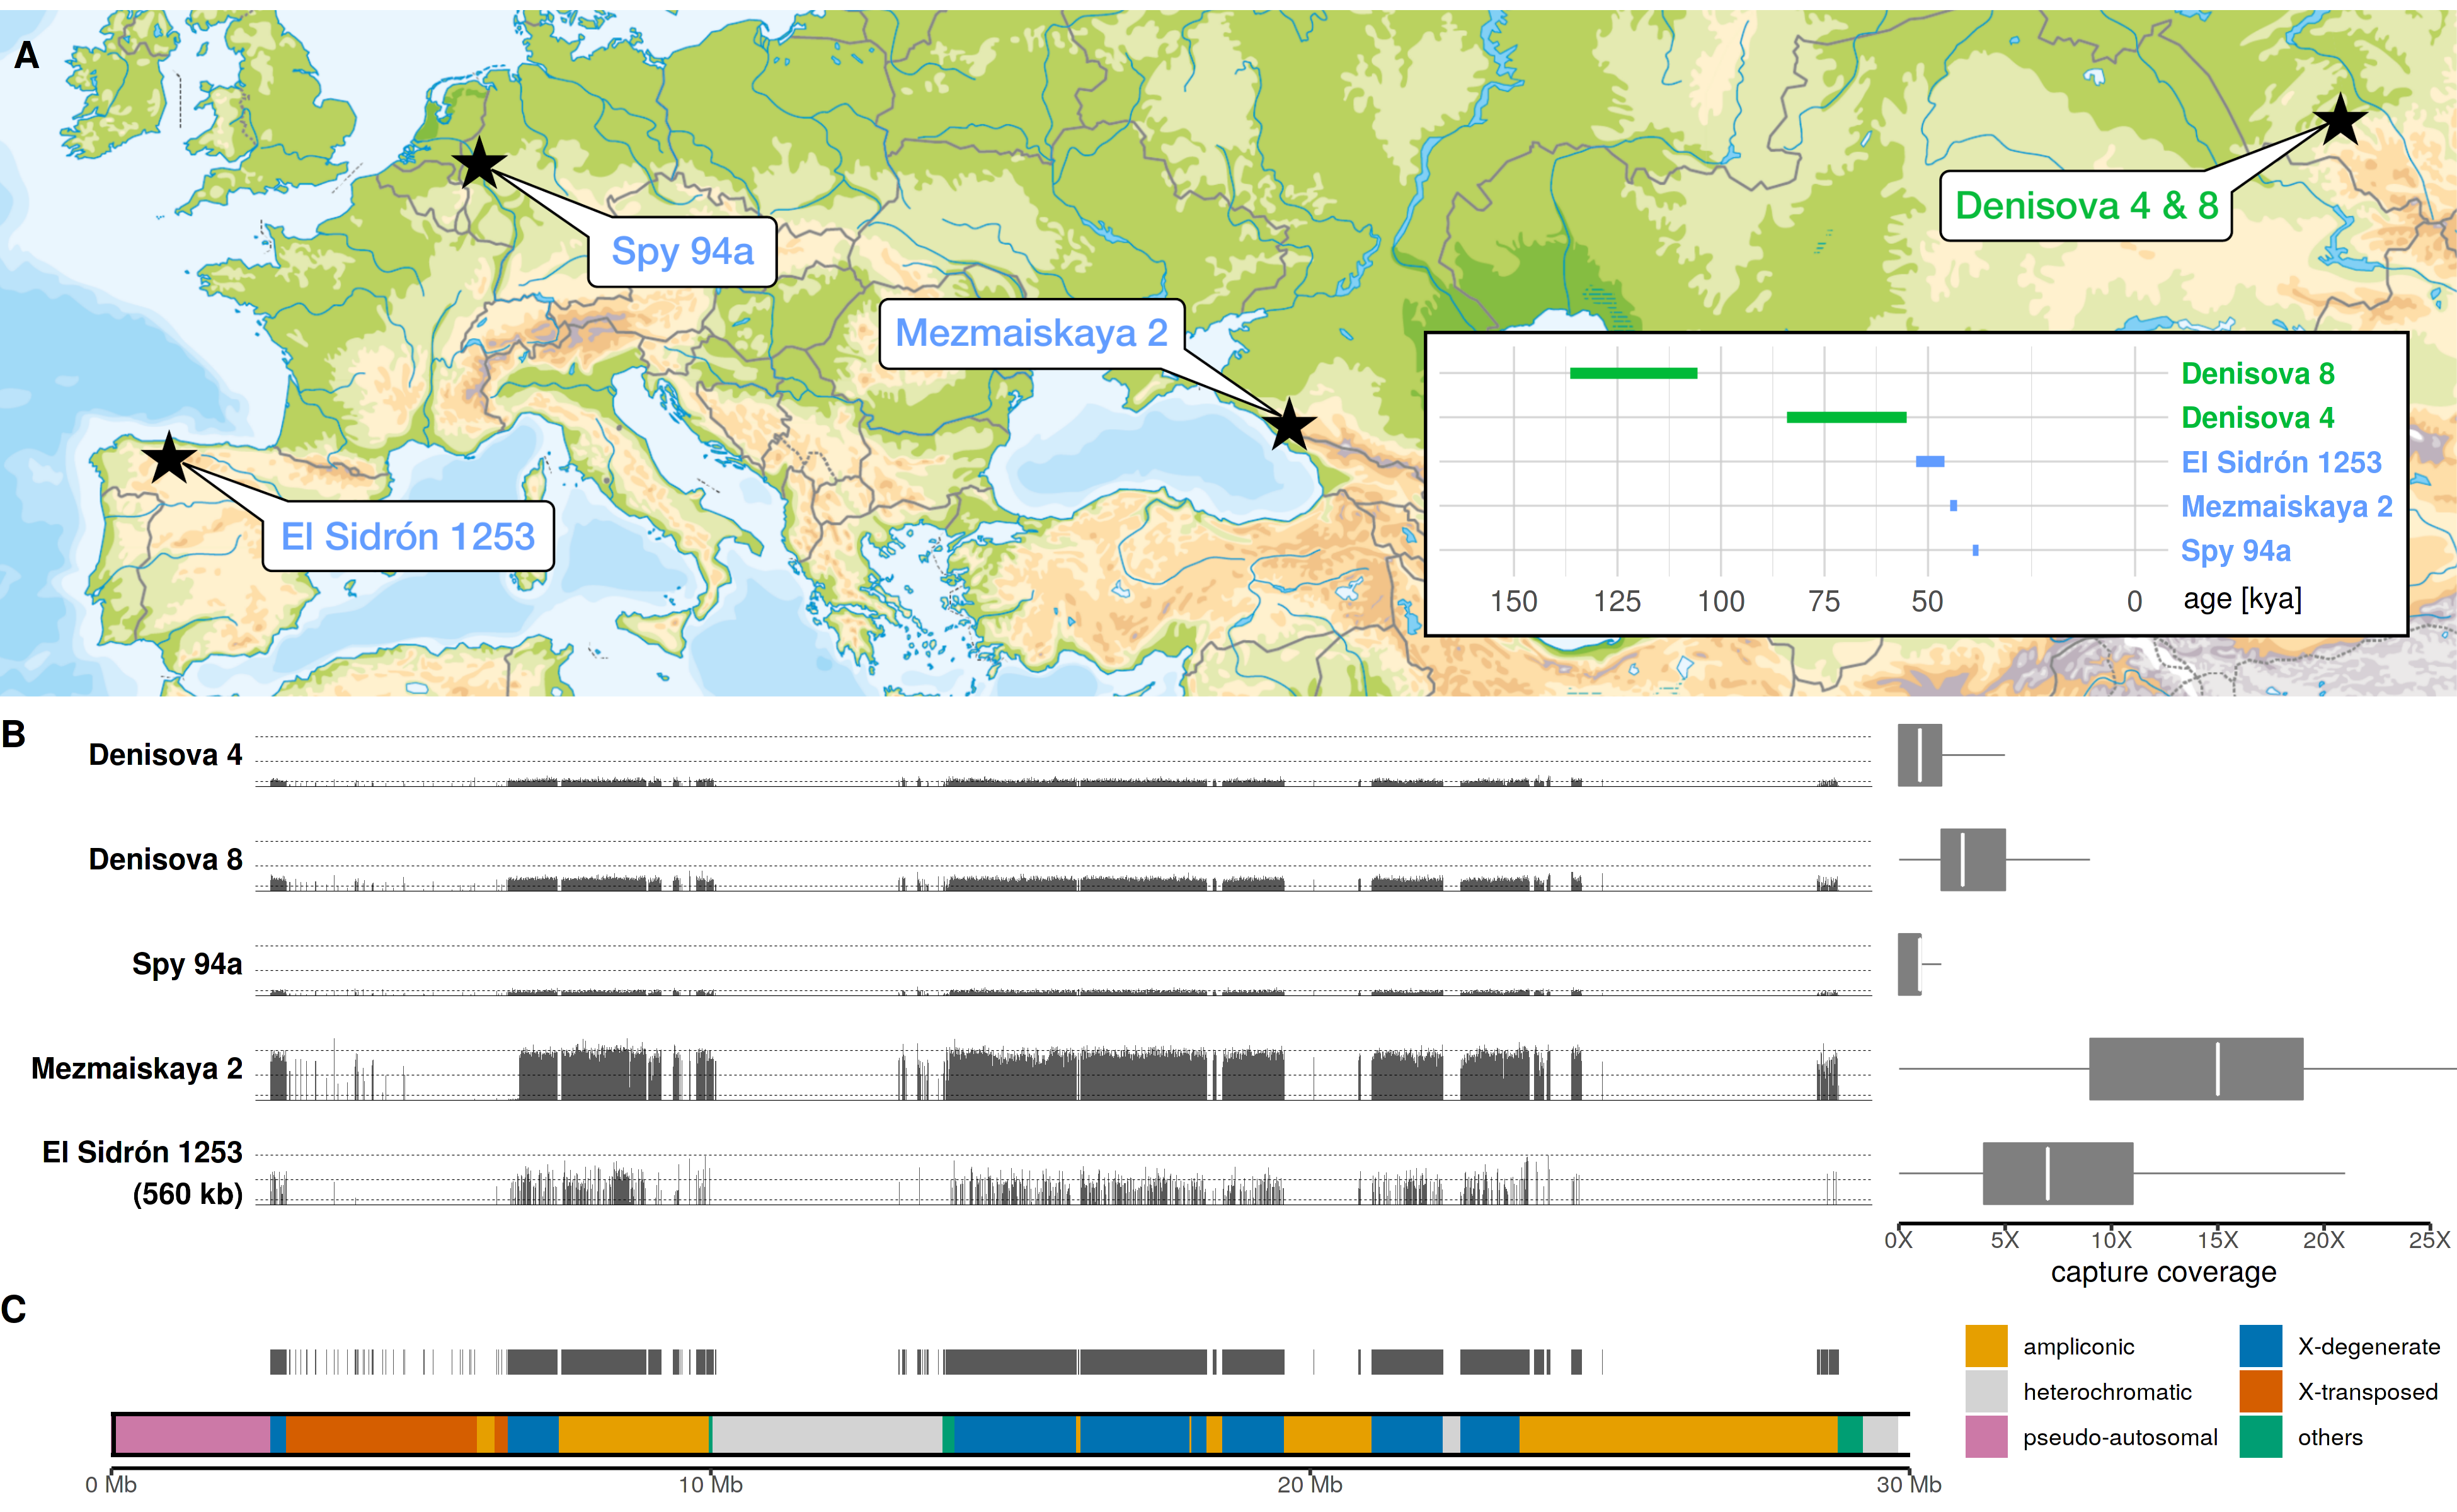

In [7]:
set_dim(13, 8)

plot_grid(
    p_mapages, p_coverage,
    nrow = 2, labels = c("A", ""),
    rel_heights = c(1, 1.14), vjust = 2.5
)

# Figure 2

In [8]:
# this also loads a "colors" vector from phylogeny.ipynb!
load(here("data/rds/phylogeny.RData"))

In [9]:
step1 <- readRDS(here("data/rds/step1.rds"))
tmrca_df <- readRDS(here("data/rds/tmrca_df.rds"))

In [10]:
p_tmrca <- plot_tmrca(stat = "new", afr = "a00", mindp = 3, sites = "nodmg", filt = "filt50",
           exclude = c(paste0("mez2_dp", 1:10), "elsidron1", "shotgun_mez2", "shotgun_spy1", "mez2_snpad",
                       "den", "den_snpad", "den4_snpad", "spy1_snpad", "den8_snpad"))

Warning message:
“Unknown levels in `f`: El Sidrón 1253 (118 kb, filtered), El Sidrón 1253 (118 kb, unfiltered)”Warning message:
“Unknown levels in `f`: Denisova 4 & 8 (snpAD)”Warning message:
“Unknown levels in `f`: El Sidrón 1253 (118 kb, filtered), El Sidrón 1253 (118 kb, unfiltered)”Warning message:
“Unknown levels in `f`: Denisova 4 & 8 (snpAD)”

In [11]:
set_dim(6, 5)

colors <- scales::hue_pal()(3)

p_tree <- ggtree(tr, ladderize = F) +
    geom_text2(nudge_y = 0.25, nudge_x = -0.0006, aes(label = bootstrap,
               subset = node %in% c(den_node, neand_node, amh_node, amhneand_node, root_node, mezsidron_node))) +

    geom_rootedge(rootedge = root_node) +

    guides(color = F)

p_tree <- p_tree %<+% df +
    geom_tiplab(aes(color = set), offset = 0.0002, size = 5) +
    geom_point2(aes(subset = node %in% c(amhneand_node, root_node, amh_node)), size = 5,
                color = colors[c(2, 3, 1)]) +
    scale_color_manual(values = c(colors[1], colors[2], colors[3], "black")) +
    coord_capped_cart(gap = 1, x = c(-0.00045, 0.013), bottom = "both", left = "none")

p_tree <- p_tree %>% scaleClade(amh_node, 0.3) %>%
    collapse(node = nonafr_node, "max", clade_name = "non-Africans")

p_tree <- p_tree + geom_nodelab(aes(subset = node == nonafr_node), vjust = 5.7, angle = 90, size = 5)

Warning message:
“Removed 24 rows containing non-finite values (stat_root_edge).”

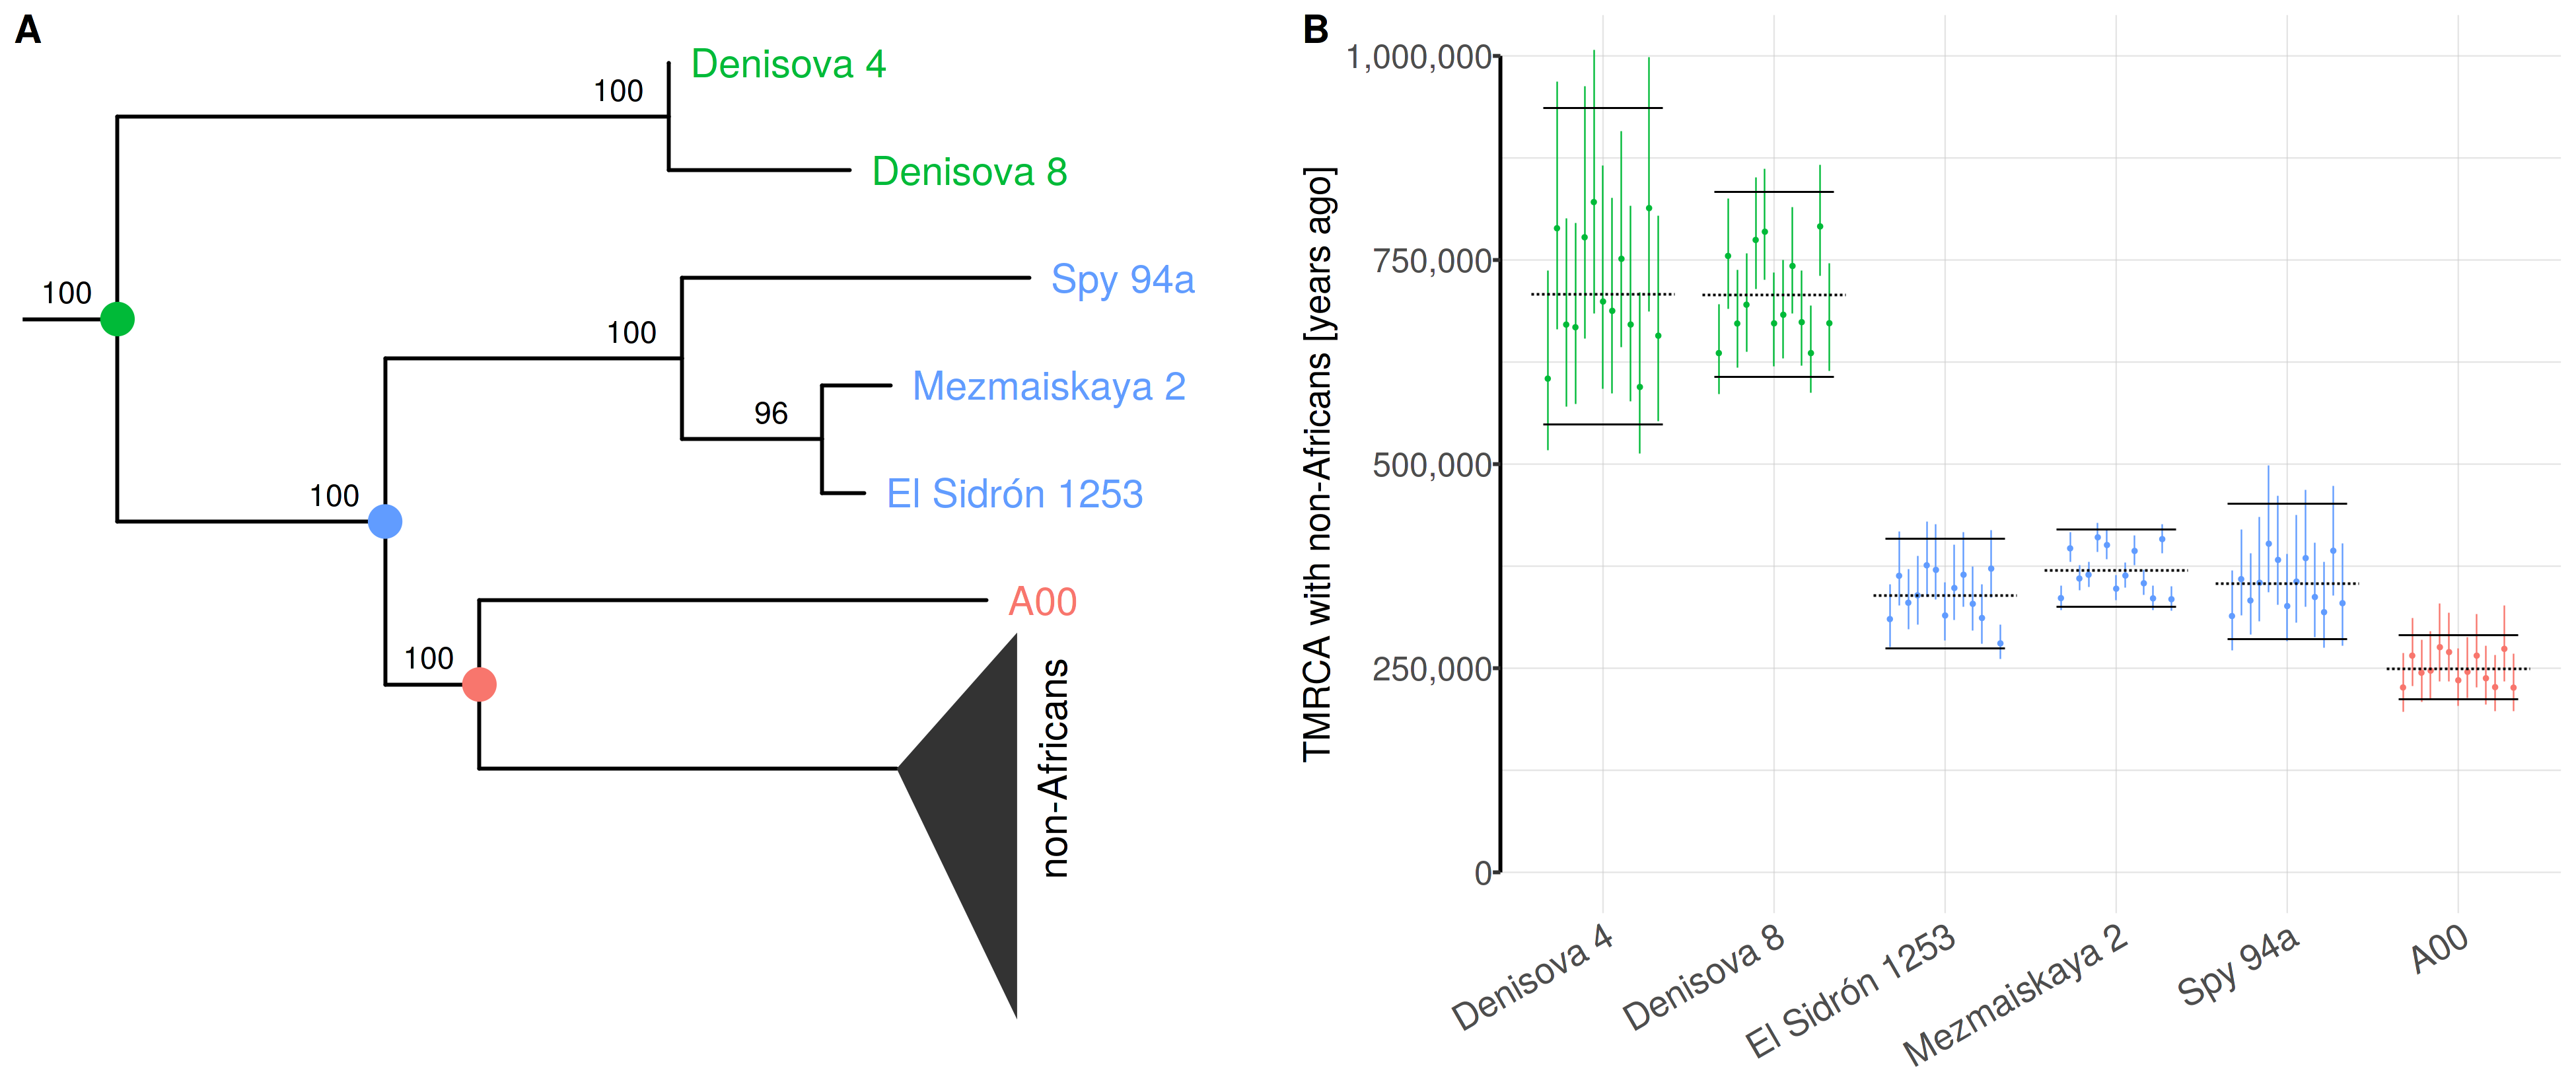

In [12]:
set_dim(13, 5.5)

plot_grid(p_tree, p_tmrca, labels = c("A", "B"))

# Figure 3

Plot probability trajectories (reformat the factors from intervals to average % values):

In [13]:
prob_traj_fitness <- readRDS(here("data/rds/prob_traj_fitness.rds")) %>%
    group_by(gen, time, fitness_bin) %>%
    summarise_all(mean) %>%
    filter(gen <= 800)

In [14]:
prob_traj_fitness$fitness_bin <-
    prob_traj_fitness$fitness_bin %>%
    str_replace("\\((.*),.*", "\\1") %>%
    as.numeric

In [15]:
unique(prob_traj_fitness$fitness_bin)

[1] 0.000 0.005 0.015 0.025 0.035 0.045 0.055 0.065 0.075 0.085 0.095 0.105
[13] 0.115 0.125 0.135 0.145

In [16]:
paste0("~", 100 * (0.005 + unique(prob_traj_fitness$fitness_bin)), "%")

[1] "~0.5%" "~1%"   "~2%"   "~3%"   "~4%"   "~5%"   "~6%"   "~7%"   "~8%"  
[10] "~9%"   "~10%"  "~11%"  "~12%"  "~13%"  "~14%"  "~15%"

In [17]:
levels <- paste0("~", 100 * (0.005 + unique(prob_traj_fitness$fitness_bin)), "%")

In [18]:
prob_traj_fitness$fitness_bin <-
    prob_traj_fitness$fitness_bin %>%
    {paste0("~", 100 * (. + 0.005), "%")} %>%
    factor(levels = levels)

In [19]:
prob_traj_fitness %>% head

gen,time,fitness_bin,gene_total,admix_time,admix_rate,prob_fix,ratio
<int>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,0,~0.5%,157142.9,344047.6,0.05,0,0.002784788
0,0,~1%,404878.0,326219.5,0.05,0,0.009601673
0,0,~2%,687096.8,317741.9,0.05,0,0.019927795
0,0,~3%,972413.8,333620.7,0.05,0,0.029553742
0,0,~4%,1150000.0,317307.7,0.05,0,0.039603574
0,0,~5%,1285000.0,308750.0,0.05,0,0.048857962


In [20]:
p_traj <- prob_traj_fitness %>%
    filter(fitness_bin %in% paste0("~", 1:10, "%")) %>%
    ggplot(aes(time, prob_fix, color = fitness_bin)) +
            geom_line(aes(group = interaction(gene_total, admix_time))) +
        labs(color = "fitness\nreduction",
             y = "replacement probability",
             x = "time after gene flow [years]") +
    theme_classic() +
    background_grid(major = "xy", minor = "xy", size.major = 0.3, size.minor = 0.1,
                    color.major = rgb(0.8, 0.8, 0.8, alpha = 0.75)) +
    theme(
        text = element_text(size = 12),
        axis.line = element_blank(),
        legend.title = element_text(size = 13)
    )

Plot TMRCA values:

In [21]:
summary_df <- tribble(
    ~"locus", ~"between",         ~"low",  ~"high",
    "Y",       "Neanderthal-AMH",  326,     419,
    "Y",       "Denisovan-AMH",    607,     833,
    "mtDNA",   "Neanderthal-AMH",  360,     468,
    "mtDNA",   "Denisovan-AMH",    720,     1410
) %>%
    mutate(mean = (low + high) / 2) %>%
    mutate(str = sprintf("%d-%d kya", low, high))

In [22]:
set_dim(1, 4, 150)

p_summary <- summary_df %>%
ggplot() +
    geom_hline(yintercept = c(550, 765), linetype = 2, size = 0.5, alpha = 0.5) +
    geom_point(aes(x = between, y = mean, color = between, shape = locus),
                    position = position_dodge(width = 1), size = 2.5) +
    geom_linerange(aes(x = between, ymin = low, ymax = high, color = between, group = locus),
                    position = position_dodge(width = 1)) +
    scale_color_manual(values = label_colors) +
    geom_rect(aes(xmin = 0, xmax = 3, ymin = 550, ymax = 765), alpha = 0.035) +
    guides(color = F, shape = F) +
    theme_classic() +
    background_grid(major = "xy", minor = "xy", size.major = 0, size.minor = 0) +
    ylab("TMRCA [kya]") +
    theme(
        axis.title.y = element_text(size = 8, margin = margin(t = 0, r = -3, b = 0, l = 0)),
        axis.title.x = element_blank(),
        axis.ticks.x = element_blank(),
        axis.line.x = element_blank(),
        axis.text.x = element_blank()
    ) +
    coord_capped_cart(ylim = c(300, 1500), left = "both", bottom = "none") +
    scale_y_continuous(breaks = seq(0, 1500, 300)) +
    scale_x_discrete(expand = c(-0.09, 0.8)) + # clump the points closer together/to the y-axis
    theme(plot.margin = unit(c(-0.3, 0, -0.51, -0.5), "cm"))

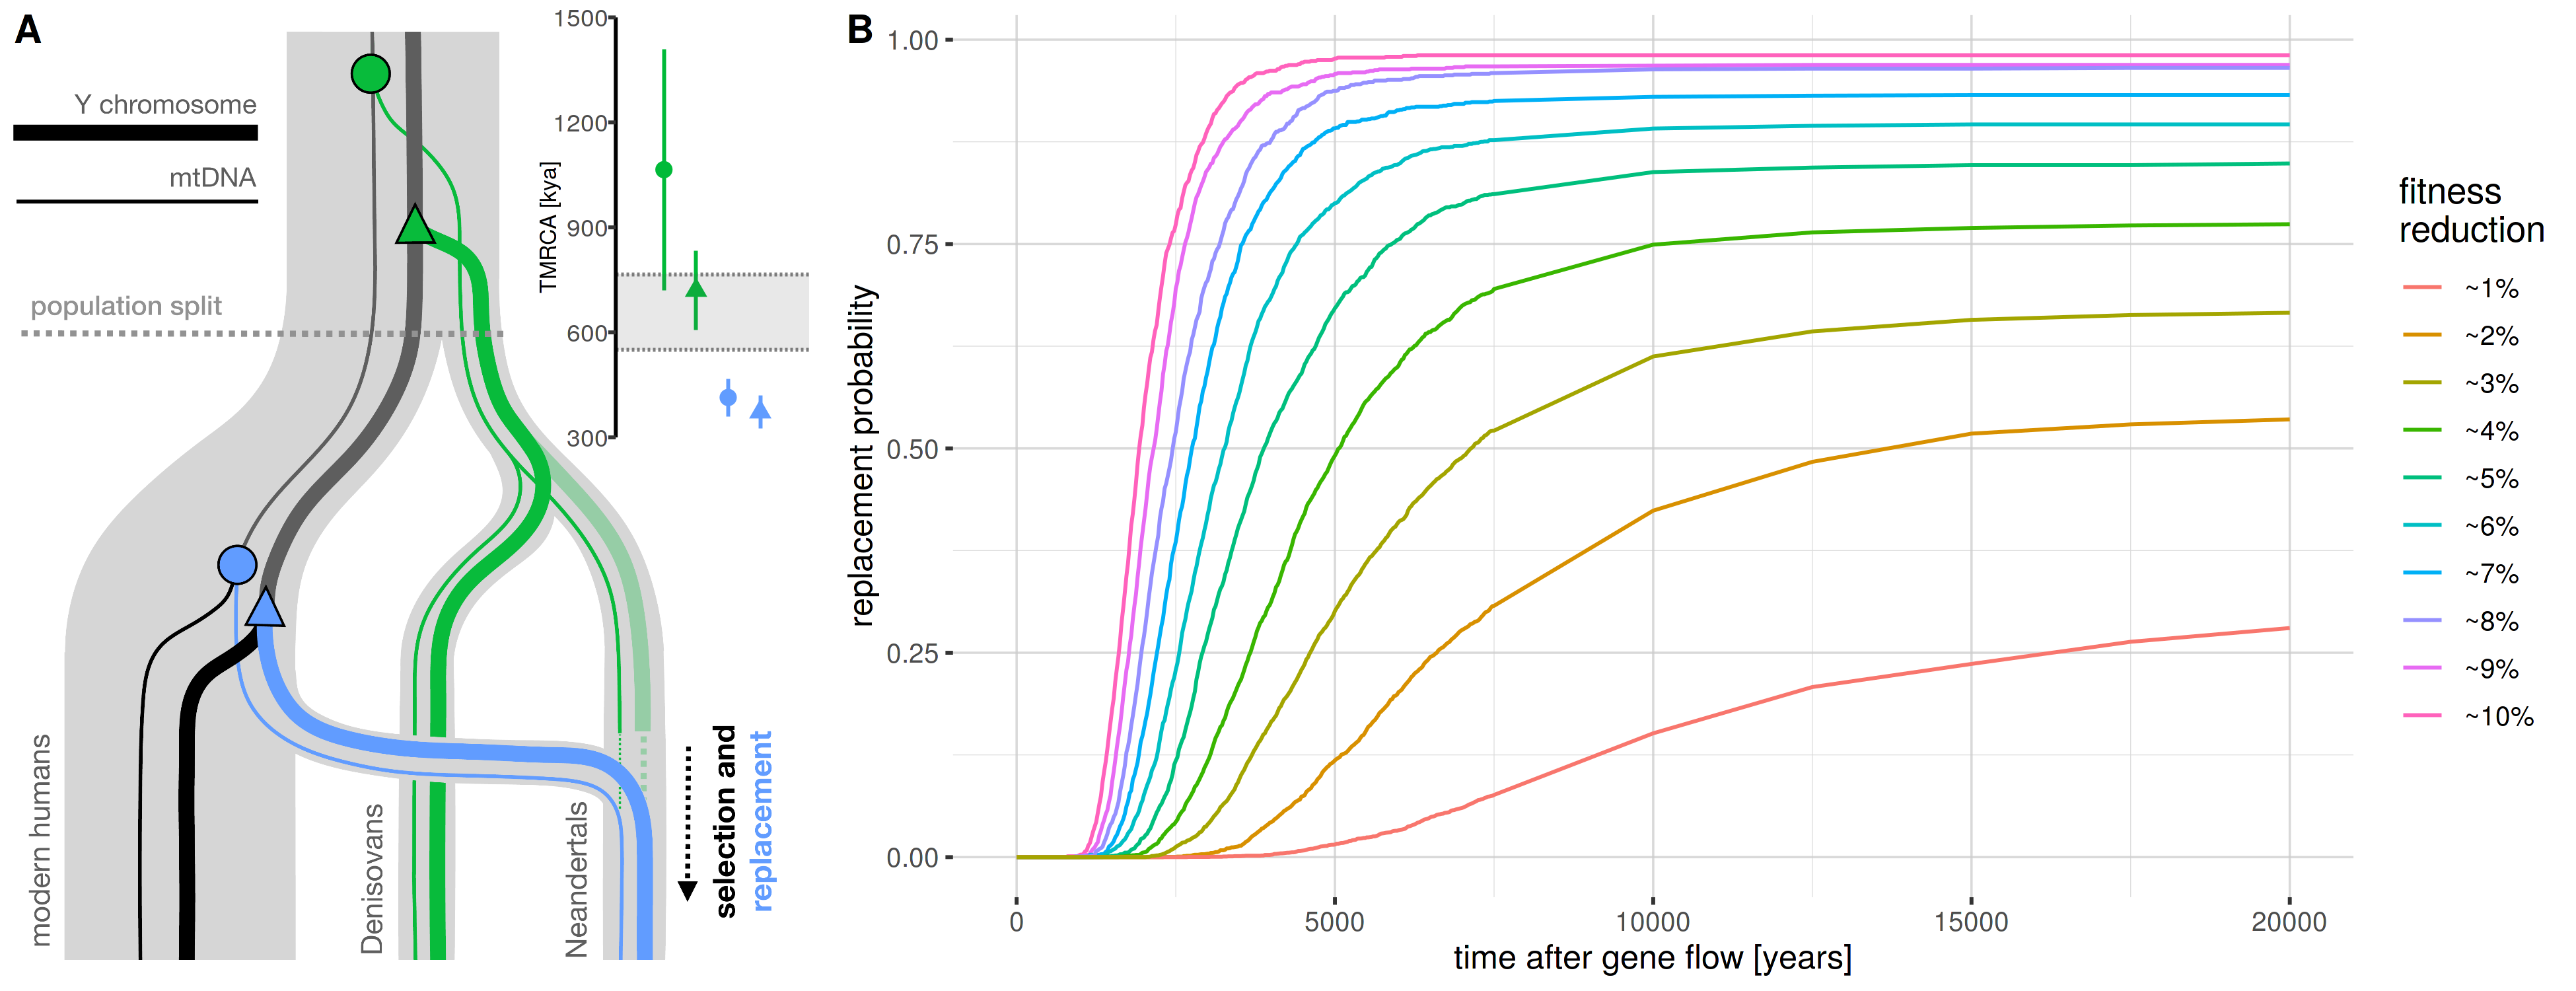

In [23]:
set_dim(13, 5)

p_diagram <- ggdraw() +
    draw_image(magick::image_read_pdf(here("figures/splits.pdf"))) +
    draw_plot(p_summary, x = 0.73, y = 0.57, width = 0.29, height = 0.41)

plot_grid(p_diagram, NULL, p_traj, labels = c("A", "", "B"), ncol = 3,
          rel_widths = c(1, 0.05, 2.2))